In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch.nn as nn
import torch.nn.functional as F

## Data Preparation

This section prepares the MNIST dataset for training and testing:

1. **Dataset Loading**:
   - The MNIST dataset is loaded and split into training and testing sets.


2. **Data Transformation**:
   - Transformations are applied to normalize the images and convert them into tensors.


3. **DataLoaders**:
   - DataLoaders are created to handle the data in batches:
     - The training DataLoader shuffles the data for better generalization.
     - The testing DataLoader does not shuffle the data.


4. **Class Labels**:
   - The class labels (digits 0-9) are defined for reference.


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

print('Training set has {} instances'.format(len(train_dataset)))
print('Validation set has {} instances'.format(len(test_dataset)))

Training set has 60000 instances
Validation set has 10000 instances


## Visualizing Sample Images

This section contains a function to display a few images from the dataset along with their labels.

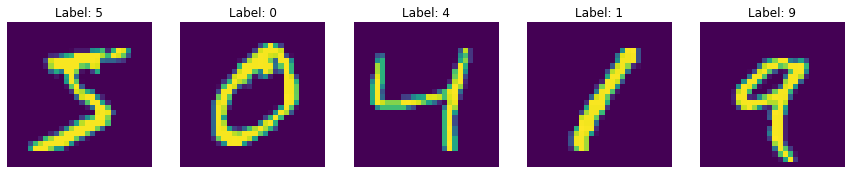

In [3]:
def show_images_from_dataset(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    
    for i in range(num_images):
        image, label = dataset[i]
        image = image.permute(1, 2, 0).numpy()
        
        image = image * 0.5 + 0.5
        
        axes[i].imshow(image)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    
    plt.show()

show_images_from_dataset(train_dataset, num_images=5)

## Model Implementation

This section defines three different neural network models for classifying MNIST digits.

1. **OneLayerMLP**:
   - This is the simplest model with only one fully connected (linear) layer.
   - The input images (28x28 pixels) are flattened into a vector of size 784 and directly mapped to 10 output classes (digits 0-9).
   - The model uses `log_softmax` at the output layer to compute class probabilities in log scale.


2. **TwoLayerMLP**:
   - This model has two hidden layers to learn more complex patterns in the data.
   - The first layer maps the input (784 features) to 128 neurons, and the second layer maps 128 neurons to 64 neurons.
   - The final layer maps the 64 neurons to 10 output classes.
   - ReLU activation is applied after each hidden layer to introduce non-linearity, which helps the model learn better.


3. **MLPWithBatchNorm**:
   - This model is similar to the TwoLayerMLP but includes batch normalization after each hidden layer.
   - Batch normalization helps stabilize and speed up training by normalizing the inputs to each layer.
   - The architecture includes:
     - A first layer with 128 neurons followed by batch normalization and ReLU activation.
     - A second layer with 64 neurons followed by batch normalization and ReLU activation.
     - A final layer that maps to 10 output classes.
   - This model is designed to improve performance and reduce overfitting compared to the TwoLayerMLP.


In [4]:
# one layer MLP
class OneLayerMLP(nn.Module):
    def __init__(self):
        super(OneLayerMLP, self).__init__()
        self.fc = nn.Linear(28 * 28, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return torch.log_softmax(self.fc(x), dim=1)

#two layer MLP
class TwoLayerMLP(nn.Module):
    def __init__(self):
        super(TwoLayerMLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.log_softmax(x, dim=1)

#two layer MLP with batch normalization
class MLPWithBatchNorm(nn.Module):
    def __init__(self):
        super(MLPWithBatchNorm, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.bn1(self.fc1(x)))
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return torch.log_softmax(x, dim=1)
    
model = MLPWithBatchNorm()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MLPWithBatchNorm(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

## Loss Function and Optimizer

This section defines the loss function and optimizer used for training the model:

1. **Loss Function**:
   - The loss function used is `nn.CrossEntropyLoss`, which is commonly used for multi-class classification problems.
   - It calculates the difference between the predicted class probabilities and the actual class labels.


2. **Optimizer**:
   - The optimizer used is `optim.SGD` (Stochastic Gradient Descent) with a learning rate of 0.01 and momentum of 0.9.
   - Momentum helps accelerate convergence by dampening oscillations during optimization.
   - An alternative optimizer, `torch.optim.Adam` (Adam) combines the benefits of momentum and adaptive learning rates.
   - Both optimizers provide a similar accuracy during training and test using MNIST dataset.

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


## Training

This section defines the training process for the model.

1. **Inputs**:
   - The function takes the model, training data loader, loss function, optimizer, and the number of epochs as inputs.


2. **Training Loop**:
   - For each epoch, the model processes the training data in batches.
   - The optimizer clears the gradients, the model makes predictions, and the loss is calculated.
   - Backpropagation is performed to compute gradients, and the optimizer updates the model's weights.


3. **Metrics**:
   - The function tracks the loss and accuracy for each epoch.
   - Loss is calculated as the average loss over all batches in the epoch.
   - Accuracy is calculated as the percentage of correctly predicted labels.


4. **Visualization**:
   - After training, the function plots graphs for training loss and accuracy over the epochs to visualize the model's performance.


In [ ]:
def train_model_with_metrics(model, train_loader, criterion, optimizer, epochs=20):

    train_losses = [] # list to store loss after each epoch
    train_accuracies = [] # list to store accuracy after each epoch

    for epoch in range(epochs):
        running_loss = 0.0 # total loss for this epoch
        correct = 0 # total correct predictions
        total = 0 # total number of images

        # loop through the training data 
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad() # clear gradient
            outputs = model(inputs) # make predictions 
            loss = criterion(outputs, labels) # calulate loss
            loss.backward() # backpropagation
            optimizer.step() # update weights


            running_loss += loss.item() # accumulate loss
            
            _, predicted = outputs.max(1) # get the predicted class
            total += labels.size(0) # update total numer of samples
            correct += predicted.eq(labels).sum().item() # count correct predictions
        
        epoch_loss = running_loss / len(train_loader) # average loss for this epoch
        epoch_accuracy = 100 * correct / total # calculate accuracy
        train_losses.append(epoch_loss) 
        train_accuracies.append(epoch_accuracy)

        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    plt.figure(figsize=(12, 5))

    # Loss graph
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    # Accuracy graph
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy')
    plt.legend()

    plt.show()

train_model_with_metrics(model, train_loader, criterion, optimizer)


Epoch 1, Loss: 0.2448, Accuracy: 93.19%
Epoch 2, Loss: 0.0997, Accuracy: 96.95%
Epoch 3, Loss: 0.0706, Accuracy: 97.80%
Epoch 4, Loss: 0.0565, Accuracy: 98.27%
Epoch 5, Loss: 0.0451, Accuracy: 98.60%
Epoch 6, Loss: 0.0379, Accuracy: 98.80%
Epoch 7, Loss: 0.0315, Accuracy: 98.97%
Epoch 8, Loss: 0.0273, Accuracy: 99.17%
Epoch 9, Loss: 0.0256, Accuracy: 99.19%
Epoch 10, Loss: 0.0211, Accuracy: 99.36%
Epoch 11, Loss: 0.0195, Accuracy: 99.33%
Epoch 12, Loss: 0.0167, Accuracy: 99.48%
Epoch 13, Loss: 0.0152, Accuracy: 99.55%
Epoch 14, Loss: 0.0138, Accuracy: 99.55%
Epoch 15, Loss: 0.0134, Accuracy: 99.62%
Epoch 16, Loss: 0.0114, Accuracy: 99.67%
Epoch 17, Loss: 0.0119, Accuracy: 99.62%
Epoch 18, Loss: 0.0117, Accuracy: 99.62%


## Evaluation

The `evaluate_model` function tests the model on the test dataset and calculates its performance:

1. **Evaluation Mode**:
   - The model is set to evaluation mode using `model.eval()` to disable training-specific features like dropout.


2. **No Gradients**:
   - The evaluation runs inside `torch.no_grad()` to save memory and computation.


3. **Loop Through Test Data**:
   - For each batch:
     - Inputs and labels are moved to the device.
     - The model predicts outputs, and the loss is calculated.
     - Correct predictions are counted by comparing predicted and actual labels.


4. **Metrics**:
   - The average loss and accuracy are calculated and printed.


In [ ]:
def evaluate_model(model, test_loader, criterion):
    model.eval()  # set the model to evaluation mode
    correct = 0  # count of correct predictions
    total = 0  # total number of samples
    running_loss = 0.0  # total loss

    with torch.no_grad():  # disable gradient calculation for evaluation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # get model predictions
            loss = criterion(outputs, labels)  # calculate loss
            running_loss += loss.item()  # accumulate loss

            _, predicted = torch.max(outputs, 1)  # get the predicted class
            total += labels.size(0)  # update the total number of samples
            correct += (predicted == labels).sum().item()  # count correct predictions

    print(f"Test Loss: {running_loss/len(test_loader)}")
    print(f"Test Accuracy: {100 * correct / total}%")
    
evaluate_model(model, test_loader, criterion)

## Visualization of Results

The `plot_confusion_matrix` function visualizes the model's performance by displaying a confusion matrix:

1. **Collect Predictions**:
   - The function iterates through the test data without calculating gradients (`torch.no_grad()`).
   - For each batch, it collects the model's predictions and the actual labels.


2. **Create Confusion Matrix**:
   - A confusion matrix is generated using `confusion_matrix` from `sklearn.metrics`.
   - It shows how often each class was correctly or incorrectly predicted.

This visualization helps identify which classes the model struggles with and where improvements can be made.

In [ ]:
def plot_confusion_matrix(model, test_loader):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(10)])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
plot_confusion_matrix(model, test_loader)


## Examine Misclassified Data

This section identifies and visualizes the images that the model predicted incorrectly:

1. **Collect Misclassified Images**:
   - For each batch, the function compares the model's predictions with the actual labels.
   - If a prediction is incorrect, the corresponding image, predicted label, and actual label are stored.


2. **Visualize Misclassified Images**:
   - A few misclassified images are displayed with its predicted label and the correct label for easy comparison.


In [ ]:
misclassified = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)
        for img, pred, label in zip(inputs, preds, labels):
            if pred != label:
                misclassified.append((img.cpu(), pred.cpu(), label.cpu()))

for img, pred, label in misclassified[:10]:
    plt.imshow(img.permute(1, 2, 0).numpy() / 2 + 0.5)
    plt.title(f'Predicted: {classes[pred]} | Actual: {classes[label]}')
    plt.show()
